In [147]:
import os 
import shutil
import subprocess
from PIL import Image
import sys
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import random as rd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
def create_preprocessed_dir():
    DIR = 'Preprocessed'
    path_dir = os.path.join("../DATA/", DIR)
    os.makedirs(path_dir)
    os.makedirs(os.path.join(path_dir, 'images'))
    os.makedirs(os.path.join(path_dir, 'labels'))
    class_names = ["fruits", "bomb"]
    
    # Create data.yaml
    yaml_path = os.path.join(path_dir, 'data.yaml')
    with open(yaml_path, 'w') as f:
        f.write(f'nc: {len(class_names)}\n')
        f.write(f'names: {class_names}')


def read_raw_class_data(dir_name):
    path = f'../DATA/RAW/{dir_name}/data.yaml'
    class_index = {}
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'names:' in line:
                names_line = line.strip().split('names:')[1].strip()
                if names_line.startswith('[') and names_line.endswith(']'):
                    names = names_line[1:-1].split(',')
                    for idx, name in enumerate(names):
                        class_index[name.strip().strip("'").strip('"')] = idx
                break
    return class_index

def preprocess_raw_dataset(newClassIndex):
    '''
    Preprocess:
    1. Adjust class index
    2. Resize all images to 640x640
    3. Adjust bounding boxes to resized images
    4. Convert all to JPG
    '''
    create_preprocessed_dir()
    raw_dir = '../DATA/RAW'
    preprocessed_dir = '../DATA/Preprocessed'
    preprocessed_images_dir = os.path.join(preprocessed_dir, 'images')
    preprocessed_labels_dir = os.path.join(preprocessed_dir, 'labels')
    index_img = 0 

    for dir_name in tqdm(os.listdir(raw_dir)):
        dir_path = os.path.join(raw_dir, dir_name)
        images_dir = os.path.join(dir_path, 'images')
        labels_dir = os.path.join(dir_path, 'labels')

        for img_name in tqdm(os.listdir(images_dir)):
            img_path = os.path.join(images_dir, img_name)
            label_name = os.path.splitext(img_name)[0] + '.txt'
            label_path = os.path.join(labels_dir, label_name)

            # Open up the label file
            with open(label_path, 'r') as f:
                label_contents = f.readlines()
            
            # Adjust class index in old label file
            if label_contents:
                adjusted_lines = []
                for line in label_contents:
                    parts = line.strip().split()
                    parts[0] = str(newClassIndex[dir_name][int(parts[0])])
                    adjusted_lines.append(' '.join(parts))
            else:
                adjusted_lines = []

            # Preprocess image
            img = Image.open(img_path)
            if img.size != (640, 640):
                img = img.resize((640, 640))
                # Convert label bounding boxes to resized image
                height = img.height
                width = img.width
                new_adjusted_lines = []
                for line in adjusted_lines:
                    class_index, x, y, w, h = map(float, line.split())
                    x = x * (640 / width)
                    y = y * (640 / height)
                    w = w * (640 / width)
                    h = h * (640 / height)
                    new_adjusted_lines.append(f"{int(class_index)} {x} {y} {w} {h}")
                adjusted_lines = new_adjusted_lines

            img = img.convert("RGB")
            img.save(os.path.join(preprocessed_images_dir, f"{dir_name}_{index_img:04d}.jpg"), "JPEG")

            # Save adjusted label file
            with open(os.path.join(preprocessed_labels_dir, f"{dir_name}_{index_img:04d}.txt"), 'w') as f_out:
                for line in adjusted_lines:
                    f_out.write(f"{line}\n")
                    
            index_img += 1


def finalize_dataset(test_size: float = 0.2, random_state = None):   

    class_names = ["fruits", "bomb"]

    # Create directories
    finalized_dir = '../DATA/Finalized'
    train_dir = os.path.join(finalized_dir, 'train')
    val_dir = os.path.join(finalized_dir, 'val')
    train_images_dir = os.path.join(train_dir, 'images')
    train_labels_dir = os.path.join(train_dir, 'labels')
    val_images_dir = os.path.join(val_dir, 'images')
    val_labels_dir = os.path.join(val_dir, 'labels')

    os.makedirs(train_images_dir)
    os.makedirs(train_labels_dir)
    os.makedirs(val_images_dir)
    os.makedirs(val_labels_dir)

    all_images_dir = '../DATA/Preprocessed/images'
    all_labels_dir = '../DATA/Preprocessed/labels'
    
    if random_state is not None:
        rd.seed(random_state)
    train_images, val_images = train_test_split(
        os.listdir(all_images_dir),
        test_size=test_size,
        random_state=random_state
    )

    # Copy images and labels to train/val directories
    print("Copying images and labels to train and val directories...")
    for img in tqdm(train_images, desc="Copying train images"):
        shutil.copy(os.path.join(all_images_dir, f"{img}"), train_images_dir)
        shutil.copy(os.path.join(all_labels_dir, f"{img.replace('.jpg', '.txt')}"), train_labels_dir)

    for img in tqdm(val_images, desc="Copying val images"):
        shutil.copy(os.path.join(all_images_dir, f"{img}"), val_images_dir)
        shutil.copy(os.path.join(all_labels_dir, f"{img.replace('.jpg', '.txt')}"), val_labels_dir)

    with open(os.path.join(finalized_dir, 'data.yaml'), 'w') as f:
        f.write(f"path: D:/Project-personal/fruitDet_CV/DATA/Finalized\n")
        f.write(f"train: ../train/images\nval: ../val/images\ntest: ../test/images\n")
        f.write(f'nc: {len(class_names)}\n')
        f.write(f'names: {class_names}')
    print("Final dataset created successfully!")


# Check class distribution in finalized dataset
def check_class_distribution():
    finalized_labels_train_dir = '../DATA/Finalized/train/labels'
    class_counts = {0: 0, 1: 0}
    class_names = ["fruits", "bomb"]
    for label_file in os.listdir(finalized_labels_train_dir):
        label_path = os.path.join(finalized_labels_train_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_index = int(line.split()[0])
                class_counts[class_index] += 1

    print("Class distribution in training set:")
    for class_index, count in class_counts.items():
        print(f"Class {class_names[class_index]}: {count} instances")
    
    finalized_labels_val_dir = '../DATA/Finalized/val/labels'
    class_counts = {0: 0, 1: 0}
    for label_file in os.listdir(finalized_labels_val_dir):
        label_path = os.path.join(finalized_labels_val_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_index = int(line.split()[0])
                class_counts[class_index] += 1

    print("Class distribution in validation set:")
    for class_index, count in class_counts.items():
        print(f"Class {class_names[class_index]}: {count} instances")


CLASS INDEXING STRUCTURE FOR PROCESSED DATASET
```
"fruits": 0
"bomb": 1
```

In [28]:
print(read_raw_class_data('DATA 1'))

{'BOMB': 0, 'CHOPPED': 1, 'FRUIT': 2}


In [152]:
print(read_raw_class_data('DATA 2'))

{'Bomb': 0, 'Fruit': 1}


In [29]:
print(read_raw_class_data('DATA 3'))

{'apple': 0, 'banana': 1, 'bomb': 2, 'coconut': 3, 'kiwi': 4, 'lemon': 5, 'orange': 6, 'peach': 7, 'pineapple': 8, 'watermelon': 9}


In [31]:
print(read_raw_class_data('DATA 4'))

{'bomb': 0, 'fruits': 1}


In [33]:
print(read_raw_class_data('DATA 5'))

{'Bomb': 0, 'Orange': 1, 'apple': 2, 'banana': 3, 'bob': 4, 'coconut': 5, 'kiwi': 6, 'lemon': 7, 'lime': 8, 'manggo': 9, 'passionFruit': 10, 'peach': 11, 'pear': 12, 'pineapple': 13, 'plum': 14, 'pomegranate': 15, 'starfruit': 16, 'strawberries': 17, 'waterMelon': 18}


In [24]:
read_raw_class_data('DATA 6')

{'Bomb': 0, 'Fruit': 1}

In [153]:
adjustclass_indexing = {
    'DATA 1': {0: 1, 1:0, 2:0},
    'DATA 2': {0:1, 1:0},
    'DATA 3': {0:0, 1:0, 2:1, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0},
    'DATA 4': {0:1, 1:0},
    'DATA 5': {0:1, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0},
    'DATA 6': {0:1, 1:0}
}

In [154]:
preprocess_raw_dataset(adjustclass_indexing)

100%|██████████| 6/6 [01:00<00:00, 10.09s/it]


In [155]:
finalize_dataset(test_size=0.2, random_state=42)

Copying images and labels to train and val directories...


Copying val images: 100%|██████████| 1636/1636 [00:16<00:00, 99.27it/s] 

Final dataset created successfully!


In [156]:
check_class_distribution()

Class distribution in training set:
Class fruits: 11037 instances
Class bomb: 1503 instances
Class distribution in validation set:
Class fruits: 2669 instances
Class bomb: 370 instances


Visualizing DATA 6_6848.jpg


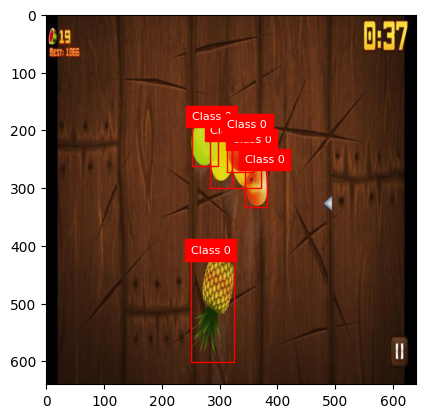

In [657]:
def visualizeImage():
    '''
    Visualize random images from the finalized dataset with bounding boxes  
    '''
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    finalized_images_dir = '../DATA/Finalized/train/images'
    finalized_labels_dir = '../DATA/Finalized/train/labels'

    random_images = rd.sample(os.listdir(finalized_images_dir), 1)[0]
    img_path = os.path.join(finalized_images_dir, random_images)
    label_path = os.path.join(finalized_labels_dir, random_images.replace('.jpg', '.txt'))

    img = Image.open(img_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    print(f"Visualizing {random_images}")
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            class_index, x, y, w, h = map(float, line.split())
            x_min = (x - w / 2) * img.width
            y_min = (y - h / 2) * img.height
            rect = patches.Rectangle((x_min, y_min), w * img.width, h * img.height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x_min, y_min, f'Class {int(class_index)}', color='white', fontsize=8, backgroundcolor='red')

    plt.show()
        
visualizeImage()